In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import os
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras.layers as layers

import PIL
import PIL.Image as pim

from sklearn.model_selection import train_test_split

In [3]:
#get the location of images
base_url = '../input/flowers-recognition/flowers'
CATEGORIES = 'daisy dandelion rose sunflower tulip'.split()

### CREATE A DATAFRAME

In [4]:
files_count = []
for i,f in enumerate(CATEGORIES):
    folder_path = os.path.join(base_url, f)
    for path in os.listdir(os.path.join(folder_path)):
        files_count.append(['{}/{}'.format(folder_path,path), f, i])
flowers_df = pd.DataFrame(files_count, columns=['filepath', 'class_name', 'label'])
flowers_df.head()

,filepath,class_name,label
0,../input/flowers-recognition/flowers/daisy/250...,daisy,0
1,../input/flowers-recognition/flowers/daisy/347...,daisy,0
2,../input/flowers-recognition/flowers/daisy/909...,daisy,0
3,../input/flowers-recognition/flowers/daisy/134...,daisy,0
4,../input/flowers-recognition/flowers/daisy/264...,daisy,0


In [5]:
flowers_df.class_name.value_counts()

dandelion    1055
tulip         984
rose          784
daisy         769
sunflower     734
Name: class_name, dtype: int64

### GET ONLY 500 SAMPLES PER CATEGORY

In [6]:
SAMPLE_PER_CATEGORY = 500
flowers_df = pd.concat([flowers_df[flowers_df['class_name']== i][:SAMPLE_PER_CATEGORY] for i in CATEGORIES])

In [7]:
flowers_df.class_name.value_counts()

rose         500
daisy        500
sunflower    500
dandelion    500
tulip        500
Name: class_name, dtype: int64

### SHOW SAMPLE IMAGE

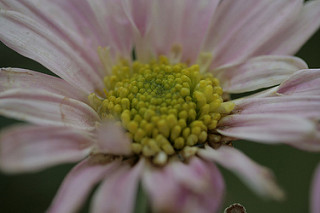

In [8]:
pim.open(flowers_df.filepath[0])

In [9]:
#split the data
X = flowers_df['filepath']
y = flowers_df['label']

train, test, label_train, label_test = train_test_split(X, y, test_size=0.2, random_state=101)

### CREATE A TENSOR DATASET

In [10]:
#convert data as a tensor
train_paths = tf.convert_to_tensor(train.values, dtype=tf.string)
train_labels = tf.convert_to_tensor(label_train.values)

test_paths = tf.convert_to_tensor(test.values, dtype=tf.string)
test_labels = tf.convert_to_tensor(label_test.values)

In [11]:
#create a tensor data set
train_data = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

In [12]:
#function to load the image and convert them as an array
def map_fn(path, label):
    image = tf.image.decode_jpeg(tf.io.read_file(path))

    return image, label

#apply the function
train_data = train_data.map(map_fn)
test_data = test_data.map(map_fn)

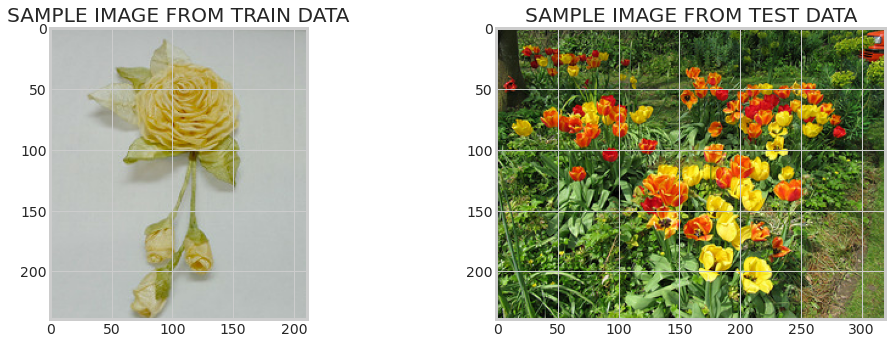

In [13]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
for i,l in train_data.take(1):
    ax[0].set_title('SAMPLE IMAGE FROM TRAIN DATA');
    ax[0].imshow(i);
for i,l in test_data.take(1):
    ax[1].set_title('SAMPLE IMAGE FROM TEST DATA');
    ax[1].imshow(i);

### IMAGE PROCESSING

In [14]:
IMAGE_SIZE = 150
#image preprocessing
def preprocessing(image, label):
    """
    returns a image that is reshaped and normalized
    """
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    
    return image, label

#apply the function
train_data = train_data.map(preprocessing)
test_data = test_data.map(preprocessing)

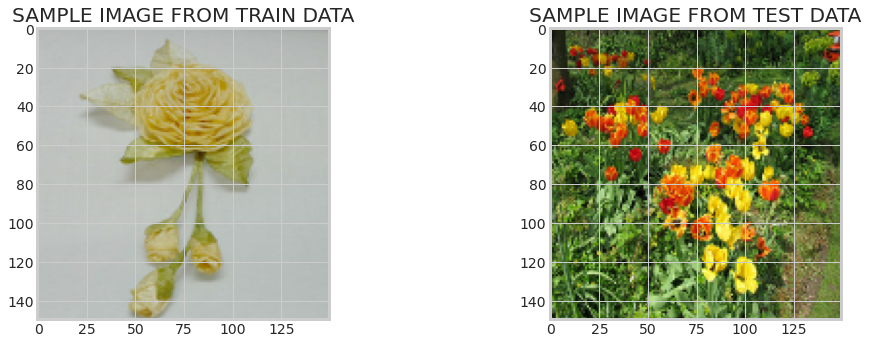

In [15]:
#show the processed images
fig, ax = plt.subplots(1,2, figsize = (15,5))
for i,l in train_data.take(1):
    ax[0].set_title('SAMPLE IMAGE FROM TRAIN DATA');
    ax[0].imshow(i);
for i,l in test_data.take(1):
    ax[1].set_title('SAMPLE IMAGE FROM TEST DATA');
    ax[1].imshow(i);

### BATCH THE IMAGES

In [16]:
#batch the images
BATCH_SIZE = 32

train_batches = train_data.batch(BATCH_SIZE)
test_batches = test_data.batch(BATCH_SIZE)

for i, l in train_batches.take(1):
    print('Train Data Shape',i.shape)
for i, l in test_batches.take(1):
    print('Test Data Shape',i.shape)

Train Data Shape (32, 150, 150, 3)
Test Data Shape (32, 150, 150, 3)


### TRANSFER LEARNING

In [17]:
#define input shape
inp_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

#load a pretrained model for feature map extraction of images
base_model = tf.keras.applications.InceptionV3(input_shape=inp_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

In [18]:
#let's try to pass an image to the model to verify the output shape
for i,l in train_batches.take(1):
    pass
base_model(i).shape

TensorShape([32, 3, 3, 2048])

In [19]:
#disable the training property (we dont want to change the convolutional base that was already trained)
base_model.trainable = False

### ADD A DENSE LAYER FOR CLASSIFICATION

In [20]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(CATEGORIES), activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 22,065,701
Trainable params: 262,917
Non-trainable params: 21,802,784
_________________________________________________________________


In [21]:
#compile the model
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
#fit the model
model.fit(train_batches,
          epochs=20,
          validation_data=(test_batches))

Epoch 1/10
63/63 [==============================] - 6s 101ms/step - loss: 0.1589 - accuracy: 0.9510 - val_loss: 0.7246 - val_accuracy: 0.7980
Epoch 2/10
63/63 [==============================] - 6s 100ms/step - loss: 0.1579 - accuracy: 0.9465 - val_loss: 0.6555 - val_accuracy: 0.8120
Epoch 3/10
63/63 [==============================] - 6s 95ms/step - loss: 0.1400 - accuracy: 0.9495 - val_loss: 0.6803 - val_accuracy: 0.8180
Epoch 4/10
63/63 [==============================] - 6s 99ms/step - loss: 0.1290 - accuracy: 0.9535 - val_loss: 0.7418 - val_accuracy: 0.8040
Epoch 5/10
63/63 [==============================] - 6s 95ms/step - loss: 0.1083 - accuracy: 0.9615 - val_loss: 0.7695 - val_accuracy: 0.8200
Epoch 6/10
63/63 [==============================] - 6s 98ms/step - loss: 0.1246 - accuracy: 0.9590 - val_loss: 0.7670 - val_accuracy: 0.8100
Epoch 7/10
63/63 [==============================] - 6s 95ms/step - loss: 0.0987 - accuracy: 0.9690 - val_loss: 0.7824 - val_accuracy: 0.8160
Epoch 8/10


In [58]:
#lets create a function to communicate with the model

def predict(filepath, model):
    #image processing
    img = tf.image.decode_image(tf.io.read_file(filepath))
    img = tf.cast(img, tf.float32)
    img = img / 255.
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    
    #convert to tensor
    img = tf.convert_to_tensor(img)
    img = tf.expand_dims(img, axis=0)
    
    #make a prediction
    prediction = model.predict_classes(img)[0]
    return ("THAT'S A " + str(CATEGORIES[prediction])).capitalize()

In [59]:
#test the model
predict(test.iloc[12], model)

"That's a daisy"

### WRAP UP!!

#### REFERENCE
* https://www.tensorflow.org/